In [1]:
import pandas as pd
import torch
import open_clip
from PIL import Image
from IPython.display import display

In [2]:
def strip_name(filename):
    return filename.split("/")[-1].split(".")[0]

In [3]:
ff_root = "/home/lucasmc/Documents/ufrgs/data/datasets/FairFace"
embs_path = f"{ff_root}/embeddings/val/ViT-L-14/openai"

val_df = pd.read_csv(f"{ff_root}/fface_val.csv")
rp_preds_df = pd.read_csv("vitb16-openai-RP.csv")
ragp_preds_df = pd.read_csv("vitb16-openai-RAGP.csv")
val_df = val_df.drop('service_test', axis=1)
val_df['file'] = val_df['file'].map(strip_name)
val_df.tail()

,file,age,gender,race
10949,10950,30-39,Male,White
10950,10951,50-59,Male,White
10951,10952,60-69,Male,Latino_Hispanic
10952,10953,20-29,Female,East Asian
10953,10954,40-49,Male,Latino_Hispanic


In [4]:
val_df['age'].value_counts()

age
20-29           3300
30-39           2330
3-9             1356
40-49           1353
10-19           1181
50-59            796
60-69            321
0-2              199
more than 70     118
Name: count, dtype: int64

In [5]:
val_df['race'].unique()

array(['East Asian', 'White', 'Latino_Hispanic', 'Southeast Asian',
       'Black', 'Indian', 'Middle Eastern'], dtype=object)

In [27]:
blacks = val_df[val_df['race'] == 'Black']

In [35]:
black_list = blacks.file.values.tolist()

In [38]:
black_iter = iter(black_list)

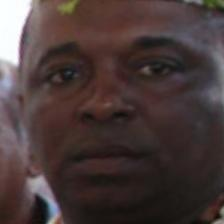

Gender: 1065    Male
Name: gender, dtype: object
Age: 1065    50-59
Name: age, dtype: object


In [218]:
img_number = next(black_iter)
img_path = f"{ff_root}/val/{img_number}.jpg"
img = Image.open(img_path)
display(img)
print(f"Gender: {val_df[val_df['file'] == img_number].gender}")
print(f"Age: {val_df[val_df['file'] == img_number].age}")

In [6]:
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-L-14', pretrained='openai')
model.eval()
tokenizer = open_clip.get_tokenizer('ViT-L-14')
text = tokenizer([
    'A photo of a white person',
    'A photo of a black person',
    'A photo of a indian person',
    'A photo of a latino hispanic person',
    'A photo of a southeast asian person',
    'A photo of a east asian person',
    'A photo of a middle eastern person',
])

In [7]:
with torch.no_grad(), torch.amp.autocast('cuda'):
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
text_features = text_features.to('cuda')

In [8]:
race_codes = {
    0: "White",
    1: "Black",
    2: "Indian",
    3: "Latino_Hispanic",
    4: "Southeast Asian",
    5: "East Asian",
    6: "Middle Eastern"
}

In [9]:
preds = {
    'file': [],
    'race_preds': []
    }

for idx, file_name in val_df['file'].items():
    preds['file'].append(str(file_name))
    img_features = torch.load(
        f"{embs_path}/{file_name}.npy", weights_only=True, map_location='cuda:0')
    probs = (100.0 * img_features @ text_features.T).softmax(dim=-1)
    pred_code = probs.cpu().numpy().argmax()
    preds['race_preds'].append(race_codes[pred_code])

In [10]:
preds_df = pd.DataFrame(preds)

In [11]:
results = val_df.set_index('file').join(preds_df.set_index('file'))
results = results.iloc[:, [0, 2, 1, 3]]
errors = results.query('race != race_preds')

In [12]:
matches = results.query('race == race_preds')

In [13]:
errors['race'].value_counts()

race
White              1882
Latino_Hispanic     785
East Asian          530
Indian              397
Southeast Asian     339
Middle Eastern      312
Black               263
Name: count, dtype: int64

In [14]:
errors['race'].value_counts()

race
White              1882
Latino_Hispanic     785
East Asian          530
Indian              397
Southeast Asian     339
Middle Eastern      312
Black               263
Name: count, dtype: int64

In [15]:
errors[errors['race'] == 'White'][errors['gender'] == 'Male']

/tmp/ipykernel_21347/523700523.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  errors[errors['race'] == 'White'][errors['gender'] == 'Male']


,age,race,gender,race_preds
file,,,,
3,30-39,White,Male,Latino_Hispanic
19,40-49,White,Male,Middle Eastern
22,40-49,White,Male,Black
45,0-2,White,Male,East Asian
47,40-49,White,Male,Latino_Hispanic
...,...,...,...,...
10928,20-29,White,Male,Latino_Hispanic
10937,30-39,White,Male,Middle Eastern
10948,10-19,White,Male,Middle Eastern


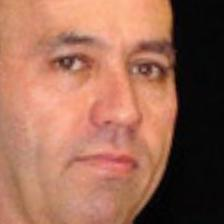

Race: White
Predicted Race: Latino_Hispanic


In [16]:
img_number = "10951"
img_path = f"{ff_root}/val/{img_number}.jpg"
img = Image.open(img_path)
display(img)
print(f"Race: {errors.loc[img_number].race}")
print(f"Predicted Race: {errors.loc[img_number].race_preds}")

In [17]:
match_keys = iter(matches[matches['race'] == 'White'].index)

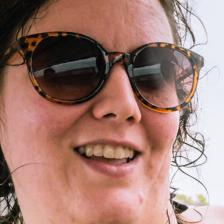

Race: White
Predicted Race: White


In [18]:
img_number = next(match_keys)
img_path = f"{ff_root}/val/{img_number}.jpg"
img = Image.open(img_path)
display(img)
print(f"Race: {matches.loc[img_number].race}")
print(f"Predicted Race: {matches.loc[img_number].race_preds}")

In [19]:
# matches = results.query('race == race_preds')
rp_matches = rp_preds_df.query('race == race_preds')
ragp_errors = ragp_preds_df.query('race != race_preds')

In [20]:
rp_matches_sa = rp_matches[rp_matches['race'] == 'Southeast Asian']
ragp_errors_sa = ragp_errors[ragp_errors['race'] == 'Southeast Asian']

In [21]:
results = []
for file in ragp_errors_sa['file'].values:
    if file in rp_matches_sa['file'].values:
        results.append(file)

In [22]:
results.__len__()

129

In [23]:
res = iter(results)

In [24]:
results

['val/28.jpg',
 'val/133.jpg',
 'val/183.jpg',
 'val/284.jpg',
 'val/292.jpg',
 'val/520.jpg',
 'val/526.jpg',
 'val/576.jpg',
 'val/585.jpg',
 'val/589.jpg',
 'val/671.jpg',
 'val/683.jpg',
 'val/738.jpg',
 'val/803.jpg',
 'val/810.jpg',
 'val/992.jpg',
 'val/1010.jpg',
 'val/1051.jpg',
 'val/1132.jpg',
 'val/1261.jpg',
 'val/1510.jpg',
 'val/1615.jpg',
 'val/1944.jpg',
 'val/1954.jpg',
 'val/1997.jpg',
 'val/2019.jpg',
 'val/2033.jpg',
 'val/2074.jpg',
 'val/2125.jpg',
 'val/2139.jpg',
 'val/2158.jpg',
 'val/2196.jpg',
 'val/2373.jpg',
 'val/2677.jpg',
 'val/2796.jpg',
 'val/2823.jpg',
 'val/2904.jpg',
 'val/2969.jpg',
 'val/3023.jpg',
 'val/3119.jpg',
 'val/3141.jpg',
 'val/3216.jpg',
 'val/3372.jpg',
 'val/3384.jpg',
 'val/3450.jpg',
 'val/3569.jpg',
 'val/3587.jpg',
 'val/3736.jpg',
 'val/3923.jpg',
 'val/3947.jpg',
 'val/4039.jpg',
 'val/4199.jpg',
 'val/4276.jpg',
 'val/4334.jpg',
 'val/4437.jpg',
 'val/4460.jpg',
 'val/4531.jpg',
 'val/4590.jpg',
 'val/4708.jpg',
 'val/4739.jpg

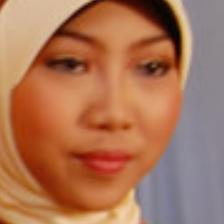

Race: 27    Southeast Asian
Name: race, dtype: object
Predicted Race: 27    East Asian
Name: race_preds, dtype: object


In [25]:
img_number = next(res)
img_path = f"{ff_root}/{img_number}"
img = Image.open(img_path)
display(img)
print(f"Race: {ragp_preds_df[ragp_preds_df['file'] == img_number].race}")
print(f"Predicted Race: {ragp_preds_df[ragp_preds_df['file'] == img_number].race_preds}")